# Comparing Word Choice

This notebook explores the differences in word choice using a fun visualization: word clouds. The most common words of each text are displayed in a cloud, with relative frequency mapped to the size of each word. This allows easy visual identification of which words are used the most in traditional vs modern text. Subsequently, this notebook also contains word clouds, for each text, grouped by word type (i.e. verb, noun, adjective, etc.).

## Imports

In [1]:
import matplotlib.pyplot as plt

import pickle
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import pandas as pd
import numpy as np

from collections import Counter
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

import pyspark
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType 
from pyspark.sql.types import ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col,array_contains
from pyspark import SparkContext
from pyspark import SparkConf

from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

In [13]:
sc = SparkContext("local[*]", "explore")
spark = SparkSession.builder.master('local[*]').appName("explore2").getOrCreate()

## Reading Data

In [14]:
# read into spark df

hackDF = spark.read.csv(path="/spring2021/project1/hacker_news_sample.csv", header=True, inferSchema=True)
blogDF = spark.read.csv('/spring2021/project1/blogtext.csv', header = True, inferSchema=True)


In [51]:
blog = pd.read_csv('/spring2021/project1/blogtext.csv')
hack = pd.read_csv('/spring2021/project1/hacker_news_sample.csv', engine='python', error_bad_lines=False)

Skipping line 188881: unexpected end of data


In [53]:
# To remove stop words from word clouds not grouped by word type. 
# This gives us the more "important" words, or words of interest.
stopWords = set(stopwords.words('english'))

In [15]:
trad1 = open("/spring2021/project1/comparison/Charles Dickens - Cities.txt", 'r')

trad2 = open("/spring2021/project1/comparison/Mary Shelley - Frankenstein.txt", 'r')

trad3 = open("/spring2021/project1/comparison/Nathaniel Hawthorne - Scarlet.txt", 'r')

trad4 = open("/spring2021/project1/comparison/Herman Melville - Moby.txt", 'r')

trad5 = open("/spring2021/project1/comparison/Scott Fitzgerald - Gatsby.txt", 'r')

trad6 = open("/spring2021/project1/comparison/Jane Austen - Pride.txt", 'r')

trad7 = open("/spring2021/project1/comparison/Conan Doyle - Sherlock.txt", 'r')

In [16]:
def start_of_file(tradfile):
    tradfile.seek(0)
    i = -1
    while True:
        i += 1
        nxt = tradfile.readline()
        if nxt[0:3] == "***":
            tradfile.readline()
            i += 1
            print("The file is at the beginning. Line: " + str(i))
            break

In [17]:
def word_dict(tradfiles):
    for tradfile in tradfiles:
        start_of_file(tradfile)
        lines = tradfile.readlines()
        wordCnt = {'stop_words':0}
        for line in lines:
            rmRet = ' '.join(line.split('\n'))
            puncRm = ''.join([c for c in rmRet if c not in string.punctuation + '“”'])
            words = puncRm.split(' ')
            for word in words:
                word = word.lower()
                if word in stopWords:
                    wordCnt['stop_words'] += 1
                elif word not in list(wordCnt.keys()) and word != '':
                    wordCnt[word] = 1
                elif word != '':
                    wordCnt[word] += 1
    return wordCnt

In [18]:
filelist = [trad1, trad2, trad3, trad4, trad5, trad6, trad7]

In [72]:
# Generates dictionaries for each book, removing stop words
moby_dict = word_dict([trad4])
moby_dict.pop('stop_words')

cities_dict = word_dict([trad1])
cities_dict.pop('stop_words')

frank_dict = word_dict([trad2])
frank_dict.pop('stop_words')

scarlet_dict = word_dict([trad3])
scarlet_dict.pop('stop_words')

gatsby_dict = word_dict([trad5])
gatsby_dict.pop('stop_words')

pride_dict = word_dict([trad6])
pride_dict.pop('stop_words')

sherlock_dict = word_dict([trad7])
sherlock_dict.pop('stop_words')

The file is at the beginning. Line: 24
The file is at the beginning. Line: 22
The file is at the beginning. Line: 26
The file is at the beginning. Line: 24
The file is at the beginning. Line: 25
The file is at the beginning. Line: 24
The file is at the beginning. Line: 21


58604

In [54]:
blog_dict = {}

for text in blog.text:
    for word in text.split():
        word = word.lower()
        if word not in stopWords:
            if word in blog_dict:
                blog_dict[word] += 1
            else:
                blog_dict[word] = 1


In [85]:
hack_dict = {}

for text in hack.text:
    text = str(text)
    clean_text = BeautifulSoup(text, 'lxml').get_text() # Gets rid of html elements
    clean_text = clean_text.replace('>', ' ')
    clean_text = clean_text.replace('<', ' ')
    clean_text = clean_text.replace('(', ' ')
    clean_text = clean_text.replace(')', ' ')
    clean_text = clean_text.replace('»', ' ')
    clean_text = clean_text.replace('.', ' ')
    clean_text = clean_text.replace('?', ' ')
    for word in clean_text.split():
        word = word.lower()
        if word not in stopWords:
            if word in hack_dict:
                hack_dict[word] += 1
            else:
                hack_dict[word] = 1
                
hack_dict.pop("nan")

34719

In [56]:
# Combines blog and hacker news dicts
modern_dict = hack_dict.copy()

for k, v in blog_dict.items():
    if k in modern_dict:
        modern_dict[k] += v
    else:
        modern_dict[k] = v


### Create Proportions Dictionaries for Each Book

The following gives us values that are proportions (all summing to 1). This allows us to combine all books, giving equal weight to each book. Otherwise, word choice from longer books would have more sway.

In [73]:
dicts = [moby_dict, cities_dict, frank_dict, scarlet_dict, gatsby_dict, pride_dict, sherlock_dict]

In [74]:
for myDict in dicts:
    total = sum(myDict.values())
    for k,v in myDict.items():
        myDict[k] = v/total

### Create Proportions Dictionary for all Books Combined

In [75]:
tradDict = {}
for book in dicts:
    for k,v in book.items():
        if k not in tradDict:
            tradDict[k] = v/len(dicts)
        else:
            tradDict[k] += v/len(dicts)

# Dictionaries by Word Type

## Modern Dict by Type

The following map-reduce functions allow us to perform tokenization, categorization, and subsequantly count frequencies of each word, storing the words and frequencies as key-value pairs in dictionaries of the desired word type (i.e. dictionaries for nouns, verbs, adjectives, etc.).

In [13]:
def tokeHTML2(x, tag_type):
    if x['text'] == None:
        ctDict = {}
    else:    
        # Remove html
        bs = BeautifulSoup(x['text'], 'lxml')
        raw = bs.get_text()

        # Tokenize
        tokens = nltk.wordpunct_tokenize(raw)
        text = nltk.Text(tokens)
        words = [w.lower() for w in text]
        tags = nltk.pos_tag(words, tagset='universal')

        # Frequency Distribution
        tag_fd = nltk.FreqDist(word for (word, tag) in tags if tag == tag_type)
        counts = [tc for tc in tag_fd.items()]
        ctDict = dict()
        for c in counts:
            ctDict[c[0]] = c[1]
    
    return ctDict

In [14]:
def redCounts(x,y):
    tot = {}
    for key in list(x.keys()):
        tot[key] = x[key]
    for key in list(y.keys()):
        if key in list(tot.keys()):
            tot[key] += y[key]
        else:
            tot[key] = y[key]
            
    return tot

### Hacker Dictionaries by Word Type

In [85]:
hackRDD = hackDF.select('text').rdd

In [89]:
# hackDistRdd = hackRDD.map(lambda x: tokeHTML2(x, tag_type = 'NOUN'))
# nouns_hack = hackDistRdd.reduce(redCounts)

# hackDistRdd = hackRDD.map(lambda x: tokeHTML2(x, tag_type = 'X'))
# other_hack = hackDistRdd.reduce(redCounts)

# hackDistRdd = hackRDD.map(lambda x: tokeHTML2(x, tag_type = 'NUM'))
# num_hack = hackDistRdd.reduce(redCounts)

# hackDistRdd = hackRDD.map(lambda x: tokeHTML2(x, tag_type = 'VERB'))
# verbs_hack = hackDistRdd.reduce(redCounts)

# hackDistRdd = hackRDD.map(lambda x: tokeHTML2(x, tag_type = 'ADJ'))
# adj_hack = hackDistRdd.reduce(redCounts)

In [94]:
# a_file = open("nouns_hack.pkl", "wb")
# pickle.dump(nouns_hack, a_file)
# a_file.close()

# a_file = open("other_hack.pkl", "wb")
# pickle.dump(other_hack, a_file)
# a_file.close()

# a_file = open("num_hack.pkl", "wb")
# pickle.dump(num_hack, a_file)
# a_file.close()

# a_file = open("verbs_hack.pkl", "wb")
# pickle.dump(verbs_hack, a_file)
# a_file.close()

# a_file = open("adj_hack.pkl", "wb")
# pickle.dump(adj_hack, a_file)
# a_file.close()

In [2]:
a_file = open("nouns_hack.pkl", "rb")
nouns_hack = pickle.load(a_file)

a_file = open("verbs_hack.pkl", "rb")
verbs_hack = pickle.load(a_file)

a_file = open("num_hack.pkl", "rb")
num_hack = pickle.load(a_file)

a_file = open("other_hack.pkl", "rb")
other_hack = pickle.load(a_file)

a_file = open("adj_hack.pkl", "rb")
adj_hack = pickle.load(a_file)

### Blog Dictionaries by Word Type

In [11]:
blogRDD = blogDF.select('text').rdd

In [15]:
# blogDistRdd = blogRDD.map(lambda x: tokeHTML2(x, tag_type = 'NOUN'))
# nouns_blog = blogDistRdd.reduce(redCounts)

# blogDistRdd = blogRDD.map(lambda x: tokeHTML2(x, tag_type = 'X'))
# other_blog = blogDistRdd.reduce(redCounts)

# blogDistRdd = blogRDD.map(lambda x: tokeHTML2(x, tag_type = 'NUM'))
# num_blog = blogDistRdd.reduce(redCounts)

# blogDistRdd = blogRDD.map(lambda x: tokeHTML2(x, tag_type = 'VERB'))
# verbs_blog = blogDistRdd.reduce(redCounts)

# blogDistRdd = blogRDD.map(lambda x: tokeHTML2(x, tag_type = 'ADJ'))
# adj_blog = blogDistRdd.reduce(redCounts)

In [19]:
# a_file = open("nouns_blog.pkl", "wb")
# pickle.dump(nouns_blog, a_file)
# a_file.close()

# a_file = open("other_blog.pkl", "wb")
# pickle.dump(other_blog, a_file)
# a_file.close()

# a_file = open("num_blog.pkl", "wb")
# pickle.dump(num_blog, a_file)
# a_file.close()

# a_file = open("verbs_blog.pkl", "wb")
# pickle.dump(verbs_blog, a_file)
# a_file.close()

# a_file = open("adj_blog.pkl", "wb")
# pickle.dump(adj_blog, a_file)
# a_file.close()

In [3]:
a_file = open("nouns_blog.pkl", "rb")
nouns_blog = pickle.load(a_file)

a_file = open("verbs_blog.pkl", "rb")
verbs_blog = pickle.load(a_file)

a_file = open("num_blog.pkl", "rb")
num_blog = pickle.load(a_file)

a_file = open("other_blog.pkl", "rb")
other_blog = pickle.load(a_file)

a_file = open("adj_blog.pkl", "rb")
adj_blog = pickle.load(a_file)

### Combining Hacker & Blog

In [4]:
nouns_modern = nouns_blog.copy()
for k, v in nouns_hack.items():
    if k in nouns_modern:
        nouns_modern[k] += v
    else:
        nouns_modern[k] = v

verbs_modern = verbs_blog.copy()
for k, v in verbs_hack.items():
    if k in verbs_modern:
        verbs_modern[k] += v
    else:
        verbs_modern[k] = v

num_modern = num_blog.copy()
for k, v in num_hack.items():
    if k in num_modern:
        num_modern[k] += v
    else:
        num_modern[k] = v

other_modern = other_blog.copy()
for k, v in other_hack.items():
    if k in other_modern:
        other_modern[k] += v
    else:
        other_modern[k] = v

adj_modern = adj_blog.copy()
for k, v in adj_hack.items():
    if k in adj_modern:
        adj_modern[k] += v
    else:
        adj_modern[k] = v

In [5]:
modern = [nouns_modern, verbs_modern, num_modern, other_modern, adj_modern]

for my_dict in modern:
    to_del = []
    for k in my_dict:
        for char in k:
            if char in string.punctuation:
                to_del.append(k)
    for k in to_del:
        if k in my_dict:
            del my_dict[k]

## Traditional Dictionaries by Word Type

In [25]:
trad1 = open("/spring2021/project1/comparison/Charles Dickens - Cities.txt", 'r')
trad2 = open("/spring2021/project1/comparison/Mary Shelley - Frankenstein.txt", 'r')
trad3 = open("/spring2021/project1/comparison/Nathaniel Hawthorne - Scarlet.txt", 'r')
trad4 = open("/spring2021/project1/comparison/Herman Melville - Moby.txt", 'r')
trad5 = open("/spring2021/project1/comparison/Scott Fitzgerald - Gatsby.txt", 'r')
trad6 = open("/spring2021/project1/comparison/Jane Austen - Pride.txt", 'r')
trad7 = open("/spring2021/project1/comparison/Conan Doyle - Sherlock.txt", 'r')
filelist = [trad1, trad2, trad3, trad4, trad5, trad6, trad7]

In [19]:
nouns_trad = {}
other_trad = {}
num_trad = {}
verbs_trad = {}
adj_trad = {}
punc_trad = {}

for file in filelist:
    
    book = file.read()
    book = book.replace('\n', ' ')
    text = word_tokenize(book)
    
    for word in nltk.pos_tag(text, tagset='universal'):
        if word[1] == 'NOUN':
            if word[0] in nouns_trad:
                nouns_trad[word[0]] += 1
            else:
                nouns_trad[word[0]] = 1
        elif word[1] == 'X':
            if word[0] in other_trad:
                other_trad[word[0]] += 1
            else:
                other_trad[word[0]] = 1
        elif word[1] == 'NUM':
            if word[0] in num_trad:
                num_trad[word[0]] += 1
            else:
                num_trad[word[0]] = 1
        elif word[1] == 'VERB':
            if word[0] in verbs_trad:
                verbs_trad[word[0]] += 1
            else:
                verbs_trad[word[0]] = 1
        elif word[1] == 'ADJ':
            if word[0] in adj_trad:
                adj_trad[word[0]] += 1
            else:
                adj_trad[word[0]] = 1
        elif word[1] == '.':
            if word[0] in punc_trad:
                punc_trad[word[0]] += 1
            else:
                punc_trad[word[0]] = 1
                


In [33]:
trad_pos = [nouns_trad, other_trad, num_trad, verbs_trad, adj_trad]

for my_dict in trad_pos:
    to_del = []
    for k in my_dict:
        for char in k:
            if char not in string.printable:
                to_del.append(k)
    for k in to_del:
        if k in my_dict:
            del my_dict[k]

In [29]:
nouns_trad

{'\ufeffThe': 6,
 'Project': 571,
 'Gutenberg': 200,
 'EBook': 8,
 'A': 129,
 'Tale': 3,
 'Cities': 4,
 'Charles': 110,
 'Dickens': 4,
 'eBook': 60,
 'use': 122,
 'anyone': 97,
 'United': 110,
 'States': 111,
 'parts': 71,
 'world': 449,
 'cost': 23,
 'restrictions': 14,
 'terms': 186,
 'License': 70,
 'online': 21,
 'laws': 89,
 'country': 219,
 'ebook': 5,
 'Title': 7,
 'Story': 6,
 'Revolution': 10,
 'Author': 8,
 'Release': 7,
 'Date': 7,
 'January': 9,
 'Most': 8,
 'December': 12,
 'Language': 7,
 'Character': 7,
 'START': 14,
 'THIS': 31,
 'PROJECT': 28,
 'GUTENBERG': 21,
 'EBOOK': 15,
 'TALE': 3,
 'OF': 57,
 'TWO': 3,
 'CITIES': 3,
 'Produced': 3,
 'Judith': 4,
 'Boss': 3,
 'David': 6,
 'Widger': 4,
 'STORY': 1,
 'THE': 115,
 'FRENCH': 3,
 'REVOLUTION': 1,
 'CONTENTS': 5,
 'Book': 8,
 'First': 24,
 'Life': 25,
 'CHAPTER': 372,
 'Period': 2,
 'II': 27,
 'Mail': 2,
 'III': 24,
 'Night': 11,
 'Shadows': 2,
 'IV': 15,
 'Preparation': 2,
 'V': 5,
 'VI': 13,
 'Shoemaker': 2,
 'Second'

## Visualizing Data

### Traditional Nouns

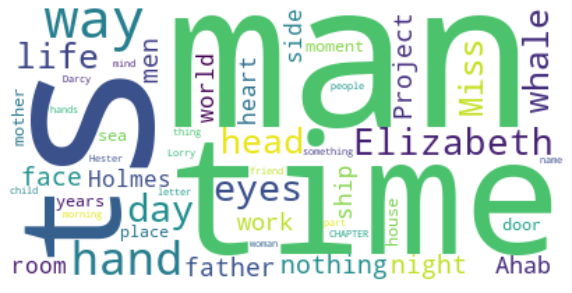

In [34]:
wordcloud = WordCloud(background_color="white", max_words = 50).generate_from_frequencies(nouns_trad)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Modern Nouns

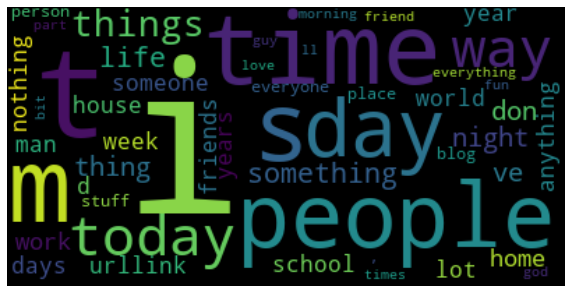

In [6]:
wordcloud = WordCloud(background_color="black", max_words = 50).generate_from_frequencies(nouns_modern)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Traditional Adjectives

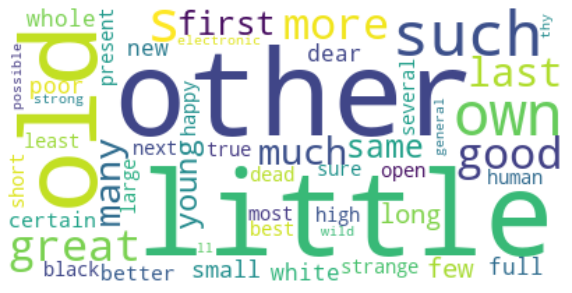

In [35]:
wordcloud = WordCloud(background_color="white", max_words = 50).generate_from_frequencies(adj_trad)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Modern Adjectives

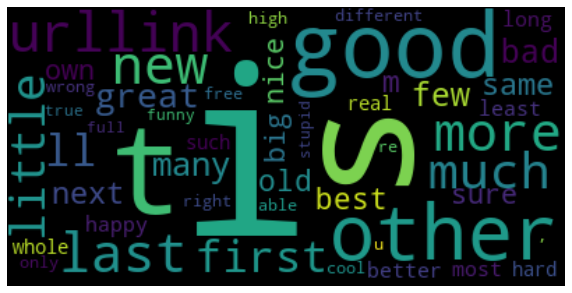

In [8]:
wordcloud = WordCloud(background_color="black", max_words = 50).generate_from_frequencies(adj_modern)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Traditional Other 

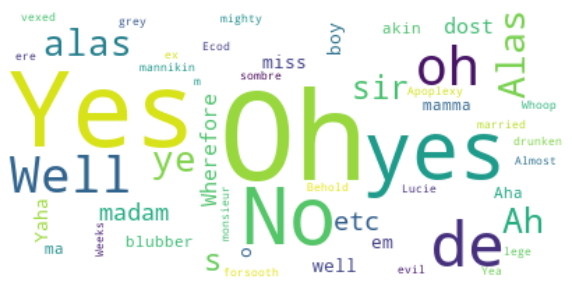

In [36]:
wordcloud = WordCloud(background_color="white", max_words = 50).generate_from_frequencies(other_trad)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Modern Other

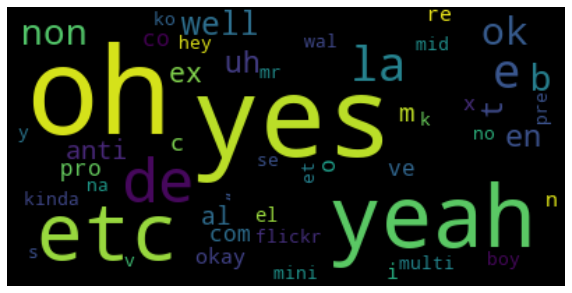

In [9]:
wordcloud = WordCloud(background_color="black", max_words = 50).generate_from_frequencies(other_modern)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Traditional Numerical

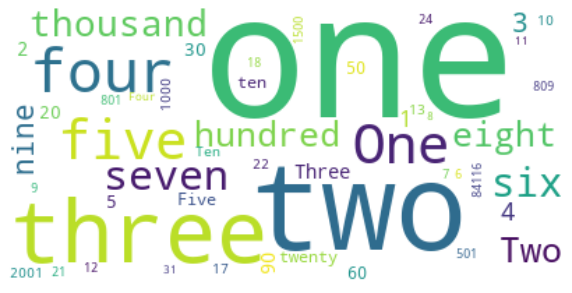

In [37]:
wordcloud = WordCloud(background_color="white", max_words = 50).generate_from_frequencies(num_trad)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Modern Numerical

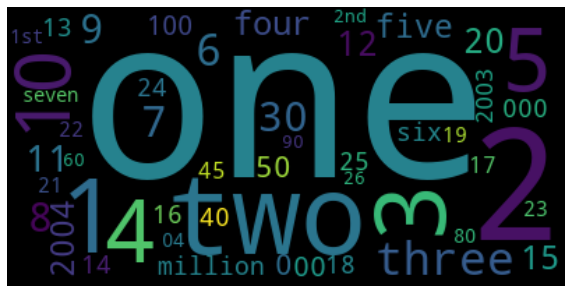

In [10]:
wordcloud = WordCloud(background_color="black", max_words = 50).generate_from_frequencies(num_modern)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Traditional Verbs

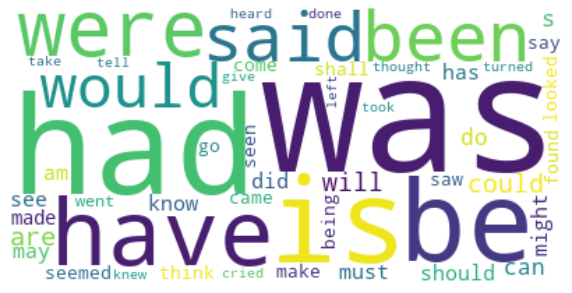

In [38]:
wordcloud = WordCloud(background_color="white", max_words = 50).generate_from_frequencies(verbs_trad)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Modern Verbs

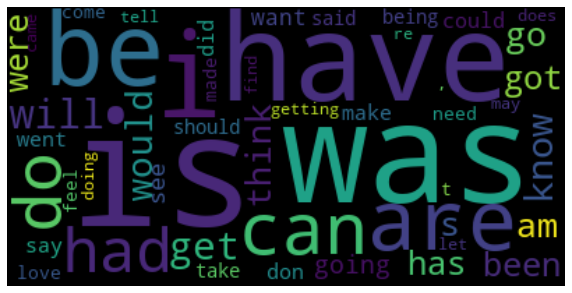

In [11]:
wordcloud = WordCloud(background_color="black", max_words = 50).generate_from_frequencies(verbs_modern)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Blog Word Cloud

In [60]:
mask = np.array(Image.open(path.join('/home/khowlett', "bloggermask.jpeg")))

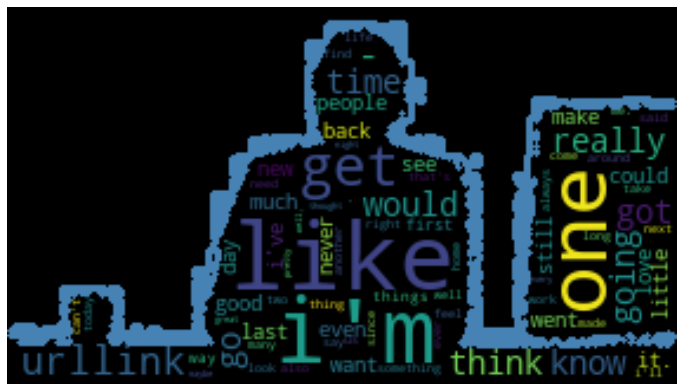

In [61]:
wordcloud = WordCloud(background_color="black", mask=mask, contour_width=3, contour_color='steelblue', max_words = 100).generate_from_frequencies(blog_dict)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12,12])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Hacker News Word Cloud

In [58]:
mask = np.array(Image.open(path.join('/home/khowlett', "hackermask.jpeg")))

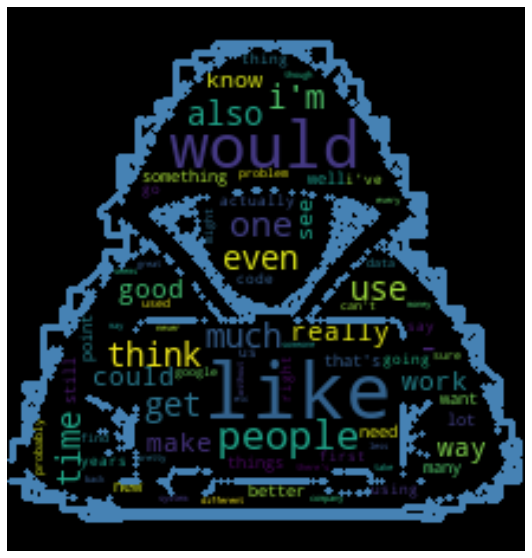

In [59]:
wordcloud = WordCloud(background_color="black", mask=mask, contour_width=3, contour_color='steelblue', max_words = 100).generate_from_frequencies(hack_dict)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Modern Word Cloud

In [62]:
mask = np.array(Image.open(path.join('/home/khowlett', "modernmask.jpeg")))

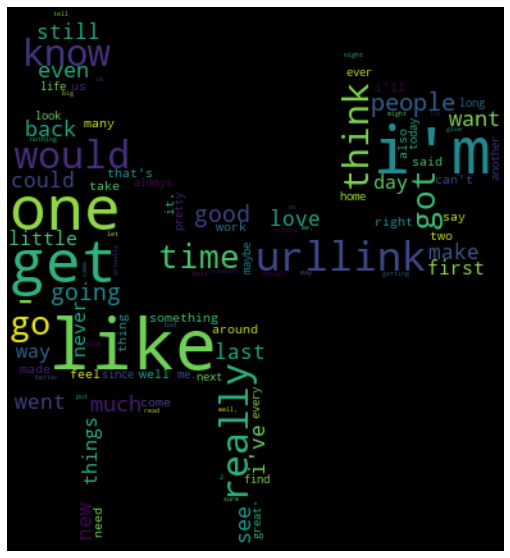

In [64]:
wordcloud = WordCloud(background_color="black", mask=mask, max_words = 100).generate_from_frequencies(modern_dict)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Traditional Word Cloud
The following word cloud displays words (non "stop words") most frequently used in all traditional text used in this project. We can see some of the most common words include "would", "said", "one", "could", "mr", "man", and "upon".

In [76]:
mask = np.array(Image.open(path.join('/home/khowlett', "bookmask5.jpeg")))

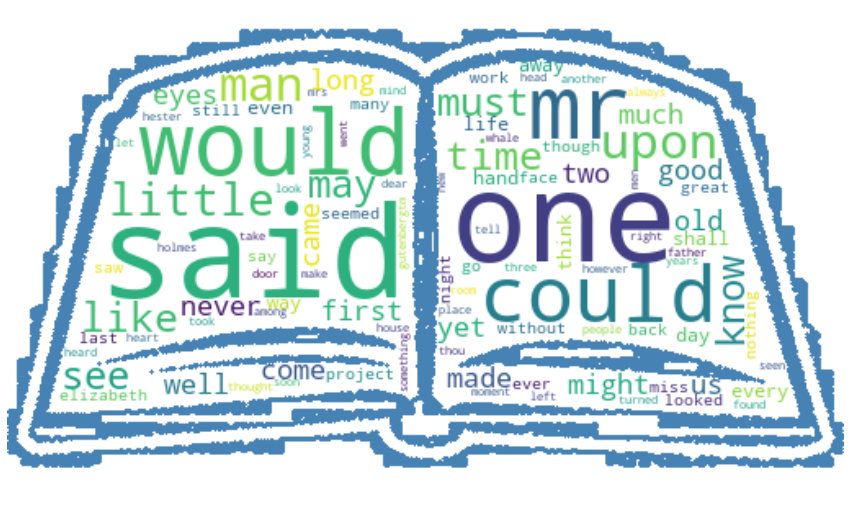

In [77]:
wordcloud = WordCloud(background_color="white", mask=mask, contour_width=3, contour_color='steelblue', max_words = 100).generate_from_frequencies(tradDict)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,15])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Moby Dick Word Cloud

Common words used in "Moby Dick" are as expected: "whale", "upon", "one", "old", "ahab", etc.

In [78]:
mask = np.array(Image.open(path.join('/home/khowlett', "whalemask.jpeg")))

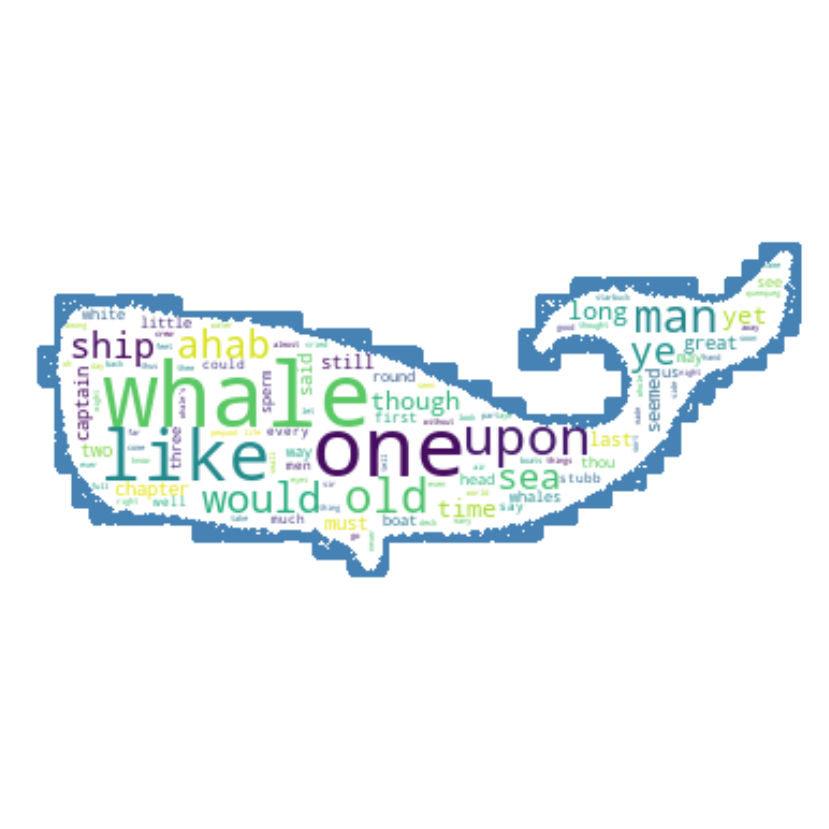

In [79]:
wordcloud = WordCloud(background_color="white", mask=mask, contour_width=3, contour_color='steelblue', max_words = 100, width=800, height=400).generate_from_frequencies(moby_dict)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,15])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Sherlock Holmes Word Cloud
In addition to words seen commmonly in traditional text, the word cloud for "Sherlock Holmes" shows that the name "Holmes" was used frequently, as expected.

In [80]:
mask = np.array(Image.open(path.join('/home/khowlett', "sherlockmask2.jpeg")))

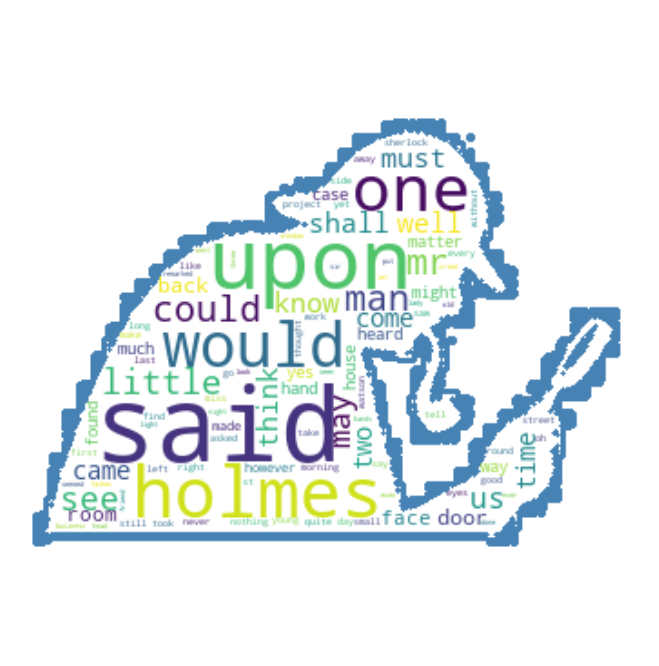

In [81]:
wordcloud = WordCloud(background_color="white", mask=mask, contour_width=3, contour_color='steelblue', max_words = 100, width=800, height=400).generate_from_frequencies(sherlock_dict)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12,12])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Great Gatsby Word Cloud
The "Great Gatsby" features quite a few words that seem more important to this particular text, such as "light", "car", "gatsby", "tom", and "house".

In [82]:
mask = np.array(Image.open(path.join('/home/khowlett', "gatsbymask3.jpeg")))

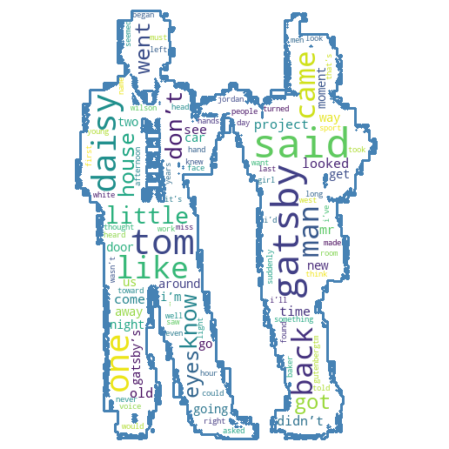

In [83]:
wordcloud = WordCloud(background_color="white", mask=mask, contour_width=3, contour_color='steelblue', max_words = 100, width=800, height=400).generate_from_frequencies(gatsby_dict)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[8,8])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Overall**  

We can see that traditional texts do vary quite a bit from modern text, in term of word choice. Where traditional texts tend to more frequently use words such as "would", "said", "one", "mr", "could", "upon", and "man", modern text (at least blog posts and hacker news) tend to use words such as "one", "get", "go", "like", "i'm", and "urllink" a lot more frequently.

**Further breaking down common words by word type:**

**Traditional Nouns**
* mr  
* time
* way
* man
* hand

**Modern Nouns**
* people
* time
* i
* day
* today

**Traditional Adjectives**
* other
* little
* old
* such
* own

**Modern Adjectives**
* i
* urllink
* last
* good
* other

**Traditional Other**
* yes
* oh
* no
* de
* alas

**Modern Other**
* yes
* oh
* de
* yeah
* etc

**Traditional Verbs**
* was
* had
* is
* be
* have

**Modern Verbs**
* was
* have
* is
* be
* are